In [1]:
import openmc_sinbad_benchmarks as osb
import os
import helpers
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
cwd = os.getcwd()

In [3]:
# read sinbad data
experiment_file = osb.ResultsFromDatabase('experiment_1.h5')
mcnp_eff3_file = osb.ResultsFromDatabase('mcnp_eff3_1.h5')
mcnp_fendl1_file = osb.ResultsFromDatabase('mcnp_fendl1_1.h5')
mcnp_fendl2_file = osb.ResultsFromDatabase('mcnp_fendl2_1.h5')

In [4]:
# read openmc files
openmc_onaxis1 = osb.ResultsFromOpenmc('statepoint.100.h5', 'reaction_rates_onaxis')
openmc_onaxis2 = osb.ResultsFromOpenmc('statepoint.100.h5', 'reaction_rates_onaxis')
openmc_offaxis = osb.ResultsFromOpenmc('statepoint.100.h5', 'reaction_rates_offaxis')
openmc_heating = osb.ResultsFromOpenmc('statepoint.100.h5', 'heating')

In [5]:
openmc_onaxis1.get_particles_per_batch

'0.13.3'

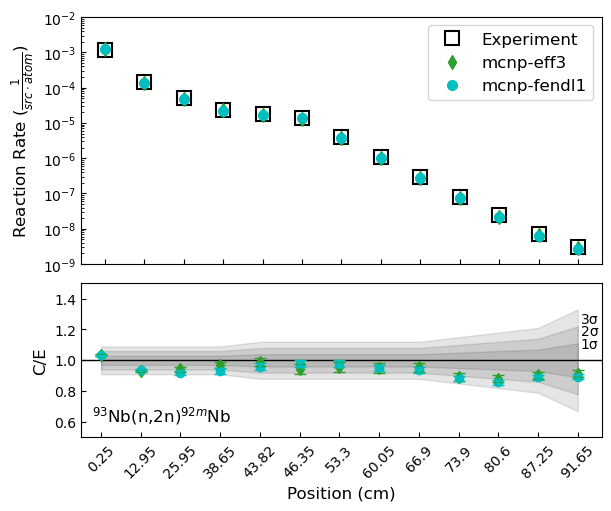

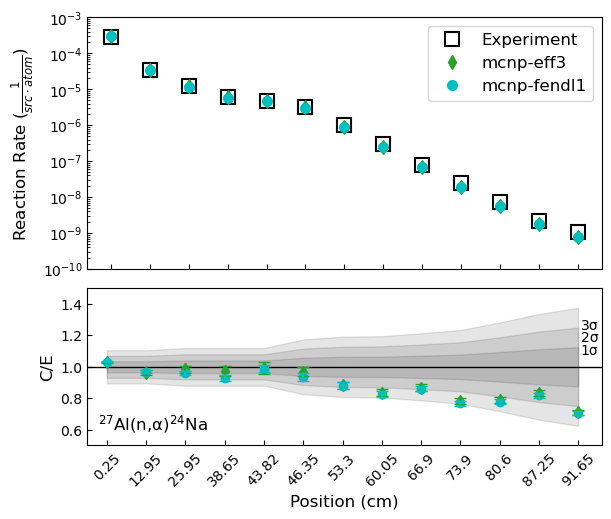

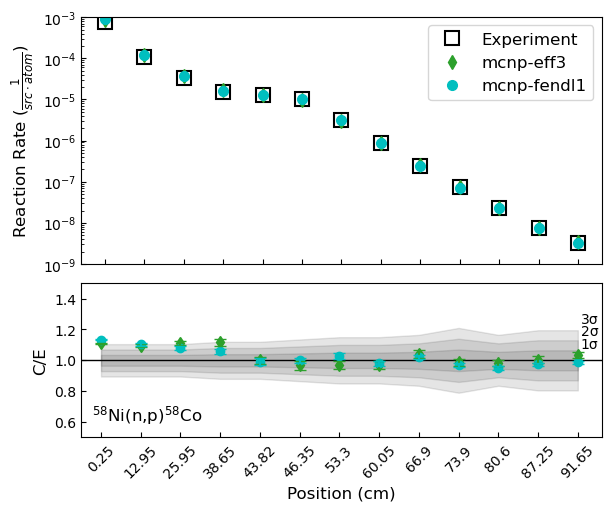

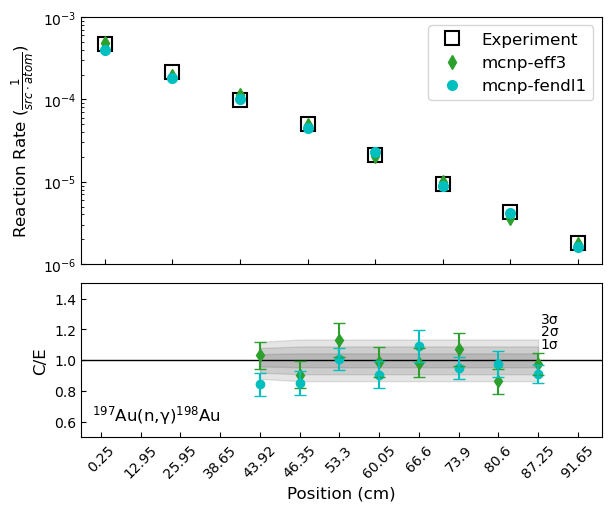

In [6]:
# initialization
foil_list = ['nb93', 'al27', 'ni58', 'au197']
reaction_labels = ['$^{93}$Nb(n,2n)$^{92m}$Nb', '$^{27}$Al(n,\u03B1)$^{24}$Na', '$^{58}$Ni(n,p)$^{58}$Co', '$^{197}$Au(n,\u03B3)$^{198}$Au']
ylabel = r'Reaction Rate $(\frac{1}{src \cdot atom})$'

for i,foil in enumerate(foil_list):

    xaxis_label = experiment_file.get_tally_xaxis(f'rr_onaxis1_{foil}')

    measured = experiment_file.get_tally_dataframe(f'rr_onaxis1_{foil}')
    mcnp_eff3 = mcnp_eff3_file.get_tally_dataframe(f'rr_onaxis1_{foil}')
    mcnp_fendl1 = mcnp_fendl1_file.get_tally_dataframe(f'rr_onaxis1_{foil}')

    try:
        mcnp_fendl2 = mcnp_fendl2_file.get_tally(f'rr_onaxis1_{foil}')
    except:
        mcnp_fendl2 = None

    
    # # read openmc results from its statepoint file
    # openmc_1 = helpers.get_openmc_tally('reaction_rates_onaxis', 'statepoint.100.h5', f'{foil}_irdff_rr')
    # openmc_1 = helpers.postprocess_openmc_foils(openmc_1, 'onaxis_group1')
    # openmc_1 = openmc_onaxis1.get_tally_dataframe(f'{foil}_irdff_rr')
    
    # plot
    dtype_label = reaction_labels[i]
    foils_onaxis_group1 = helpers.VisualizeResults()  # the plot has always to be initialized like this
    foils_onaxis_group1.add_measured_data(measured, xaxis_label, ylabel, dtype_label)  # measured data have always to be plotted
    foils_onaxis_group1.add_computed_data(mcnp_eff3, 'd', 'tab:green', 'mcnp-eff3')  # one can add as many computed data as preferred
    foils_onaxis_group1.add_computed_data(mcnp_fendl1, 'o', 'c', 'mcnp-fendl1')
    foils_onaxis_group1.add_computed_data(mcnp_fendl2, '^', 'tab:pink', 'mcnp-fendl2')
    # foils_onaxis_group1.add_computed_data(openmc_1, 'x', 'crimson', 'openmc')